# **<font color=white> 16.XGBoost Code 실습**

[목적]
  - GBM Model을 획기적인 System Design을 활용하여 개선한 XGBoost Model 실습 및 해석
  - XGBoost의 경우 Missing Value를 Model 자체 내에서 처리해주기 때문에 삭제하지 않아도 됨
  - Big Data를 빠르게 학습함

[Process]
  1. Define X's & Y
  2. Split Train & Valid dataset
  3. Modeling
  4. Model 해석

In [1]:
import os
import gc
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier, XGBRegressor
from collections import Counter

In [2]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


[Data Condition Check]

XGBoost Package의 경우 변수 Name 중 특수 문자가 들어가면 오류가 나게 되어 있음
따라서 변수이름들을 모두 전처리 해줘야함

In [4]:
# Feature Name Cleaning
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [5]:
tmp = [1, 1, 1]
set(tmp)

{1}

In [6]:
# Data Quality Checking
col = []
missing = []
level = [] 
for name in data.columns:
    
    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']), 
                     pd.DataFrame(missing, columns=['Missing Percentage']), 
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (532, 22)


In [7]:
drop_col

10    zprior
Name: name, dtype: object

In [8]:
summary

,name,Missing Percentage,Level
0,censor,0.0,2
1,event,0.0,358
2,age,0.0,52
3,wtkg,0.0,312
4,hemo,0.0,2
5,homo,0.0,2
6,drugs,0.0,2
7,karnof,0.0,4
8,oprior,0.0,2
9,z30,0.0,2


In [9]:
data.shape

(532, 22)

In [10]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [11]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


[XGBoost Parameters]
  - Package : https://xgboost.readthedocs.io/en/stable/
  - booster : Iteration 마다의 Model Run Type을 고를수 있음 (2가지)
    - gbtree : tree-based models
    - gblinear : linear models
  - silent : 학습하면서 running message를 프린트해줌 (Parameter 실험 시 안좋음)
    - 0은 프린트 안해주고, 1은 프린트해줌
  - nthread : 병렬처리 할때 core를 몇개 잡을 것인지
    - default로 잡을 수 있는 모든 core를 잡을 수 있도록 해줌
  - learning_rate : GBM에서 shrinking 하는 것과 같은 것
  - reg_lambda : L2 regularization term on weights (analogous to Ridge regression)
  - reg_alpha : L1 regularization term on weight (analogous to Lasso regression)
  - objective [default=reg:linear]
     - This defines the loss function to be minimized. Mostly used values are:
         - binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
         - multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
         - multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
  - eval_metric [ default according to objective ]
    - The metric to be used for validation data.
    - The default values are rmse for regression and error for classification.
    - Typical values are:
        -    rmse – root mean square error
        -    mae – mean absolute error
        -    logloss – negative log-likelihood
        -    error – Binary classification error rate (0.5 threshold)
        -    merror – Multiclass classification error rate
        -    mlogloss – Multiclass logloss
        -    auc: Area under the curve

[XGBoost]

  - Hyperparameter tuning
  - n_estimators, learning_rate, max_depth, reg_alpha
  - XGBoost은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
  - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음

In [12]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:
                
                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = XGBClassifier(n_estimators=n, learning_rate=l, 
                                      max_depth=m, reg_alpha=L1, objective='binary:logistic', random_state=119)
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])
                
                
                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))
                
                # Model 저장
                #import joblib
                #joblib.dump(model, './XGBoost_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(f1_score_[-1], 4)))
                #gc.collect()

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[238   3]
 [ 60  71]]
Train Acc : 0.8306451612903226
Train F1-Score : 0.6926829268292682
Test Confusion Matrix
[[105   5]
 [ 19  31]]
TesT Acc : 0.85
Test F1-Score : 0.7209302325581396
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[238   3]
 [ 60  71]]
Train Acc : 0.8306451612903226
Train F1-Score : 0.6926829268292682
Test Confusion Matrix
[[105   5]
 [ 19  31]]
TesT Acc : 0.85
Test F1-Score : 0.7209302325581396
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[238   3]
 [ 60  71]]
Train Ac

Train Confusion Matrix
[[237   4]
 [  8 123]]
Train Acc : 0.967741935483871
Train F1-Score : 0.9534883720930233
Test Confusion Matrix
[[95 15]
 [ 4 46]]
TesT Acc : 0.88125
Test F1-Score : 0.8288288288288288
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 30 <<<
n_estimators : 20, learning_rate : 0.3, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[235   6]
 [  3 128]]
Train Acc : 0.9758064516129032
Train F1-Score : 0.9660377358490565
Test Confusion Matrix
[[93 17]
 [ 1 49]]
TesT Acc : 0.8875
Test F1-Score : 0.8448275862068965
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 31 <<<
n_estimators : 20, learning_rate : 0.3, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[234   7]
 [  5 126]]
Train Acc : 0.967741935483871
Train F1-Score : 0.9545454545454546
Test Confusion Matrix


In [13]:
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_depth : {}\nBest L1-norm : {}".format(np.argmax(f1_score_),
                                                                                                                                            f1_score_[np.argmax(f1_score_)], 
                                                                                                                                            save_n[np.argmax(f1_score_)],
                                                                                                                                            save_l[np.argmax(f1_score_)],
                                                                                                                                            save_m[np.argmax(f1_score_)],
                                                                                                                                            save_L1[np.argmax(f1_score_)]))

>>> 24 <<<
Best Test f1-score : 0.8521739130434782
Best n_estimators : 20
Best Learning Rate : 0.1
Best Max_depth : 3
Best L1-norm : 0.1


In [14]:
best_model = XGBClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)], 
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='binary:logistic', 
                           random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Train Confusion Matrix
[[227  14]
 [ 11 120]]
Train Acc : 0.9327956989247311
Train F1-Score : 0.9056603773584906
Test Confusion Matrix
[[94 16]
 [ 1 49]]
TesT Acc : 0.89375
Test F1-Score : 0.8521739130434782


In [15]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.384801    event
1   0.115327    cd496
2   0.089598  preanti
3   0.089240    cd420
4   0.078008     race
5   0.055997    cd820
6   0.048826     wtkg
7   0.032533      z30
8   0.027505     cd80
9   0.027451   karnof
10  0.026762     cd40
11  0.023951      age
12  0.000000  symptom
13  0.000000    strat
14  0.000000     str2
15  0.000000        r
16  0.000000   oprior
17  0.000000     homo
18  0.000000     hemo
19  0.000000   gender
20  0.000000    drugs


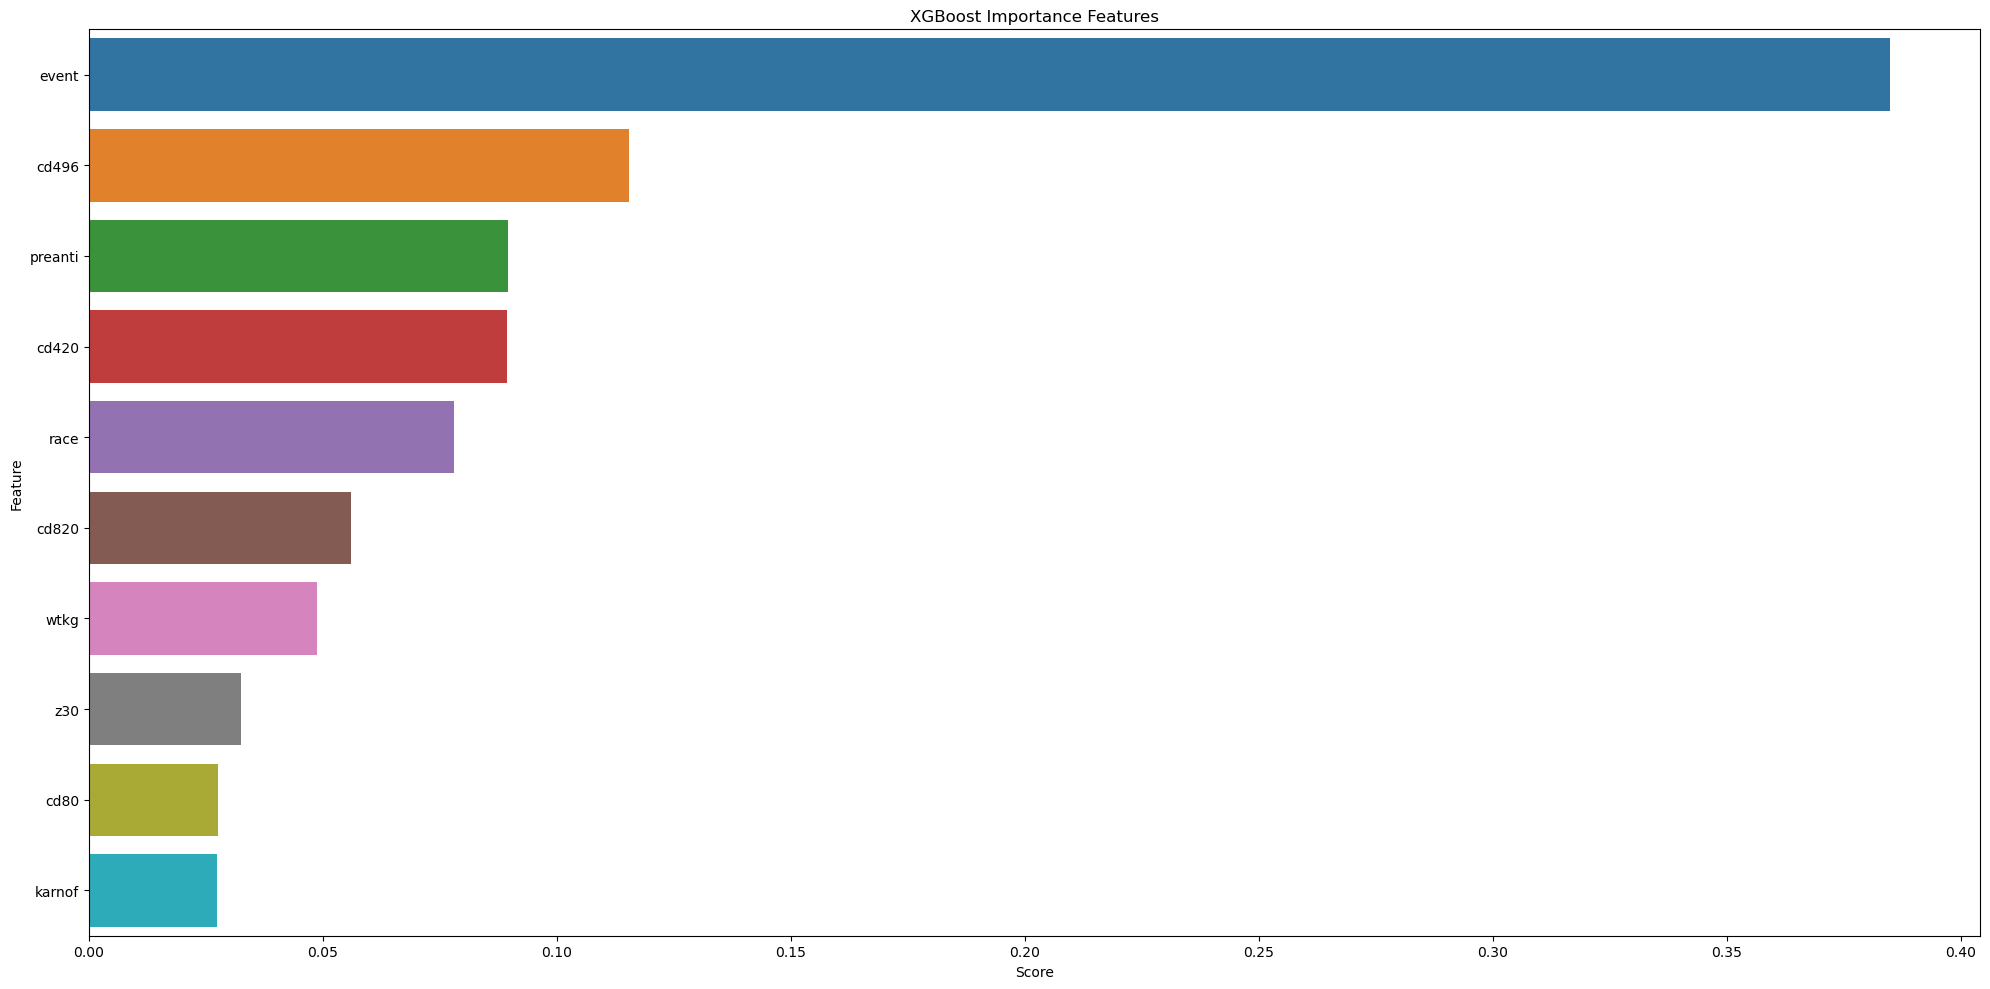

In [16]:
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()